# 레진코믹스 데이터 분석
## 부제: Decision Tree를 사용한 구매여부 예측 분류

레진 코믹스에서 실 서비스에서 추출한 65만건의 데이터를 공개해서 구매여부 예측 모델을 만들어 보는 행사를 진행하고 있어서, 배운 것을 적용해보자 한다.

![]

링크: http://tech.lezhin.com/events/data-challenge-pyconkr-2017

<br><br/>

## 목적
---
1시간 이내로 구매 여부 예측

## data형식
---
* 파일 포맷: TSV
* 파일 용량: 228M (압축해서 26M)
* 샘플 수: 650,965 건
* feature 수: 167 개
    - 1 : label 해당 유저가 목록에 진입하고 1시간 이내에 구매했는지 여부
    - 2 : 사용 플랫폼 A
    - 3 : 사용 플랫폼 B
    - 4 : 사용 플랫폼 C
    - 5 : 사용 플랫폼 D
    - 6 : 목록 진입시점 방문 총 세션 수 (범위별로 부여된 순차 ID)
    - 7 : 작품을 나타내는 해쉬
    - 8-10 : 개인정보
    - 11-110 : 주요 작품 구매 여부
    - 111 : 작품 태그 정보
    - 112 : 구매할 때 필요한 코인
    - 113 : 완결 여부
    - 114-123 : 스케쥴 정보
    - 124-141 : 장르 정보
    - 142 : 해당 작품의 마지막 에피소드 발행 시점 (범위별로 부여된 순차 ID)
    - 143 : 단행본 여부
    - 144 : 작품 발행 시점 (범위별로 부여된 순차 ID)
    - 145 : 총 발행 에피소드 수 (범위별로 부여된 순차 ID)
    - 146-151 : 작품 태그 정보
    - 152-167 : 유저의 성향 정보 (과거에 구매를 했을 때만 기록)

## 데이터 전처리
---

In [24]:
import preprocessing
data = preprocessing.data

### 데이터 특성

전처리에 사용한 데이터 Features는 3번째 개인 정보(10번째 칼럼)를 제외한 총 166개의 Features다. 여기서 NaN 값이 있는 유저의 성향정보는 구매를 안했으면 0 이라고 판단하여, 이 값들을 0 으로 다 채워주었다.

### 구매력

만화에 대한 정보와 구매자에 대한 정보가 섞여 있는데, 구매자에 관한 정보(주요 작품 구매 여부) 일부를 구매자 성향으로 바꿔보는 시도를 해보았다.

물론, 이렇게 데이터가 무엇인지를 단정 짓는 것은 틀린 발상 일수도 있으나, 조사를 통해 최대한 편향을 줄이려는 시도를 해보았다.

탐색적 분석을 한 결과 1번째 개인정보(8번째 칼럼)은 해당 유저의 일련번호 혹은 기기번호로 추측된다. 

따라서 이 정보와 주요 작품 구매여부(11~110번째 칼럼: 총100개의 칼럼, 아마도 Top100에 있는 만화 구매 여부로 추정)를 사용해서 

**'구매력(purchasing power)'**이라는 새로운 지표를 만들었다.

그 과정은 아래와 같다. 
<br><br/>

하나의 데이터(혹은 로그기록)에 나타나는 주요 작품 구매여부의 값들은 기록시점에서 해당 구매자의 누적 구매 편수를 나타내는 것으로 추정된다. 

그 근거는 주요 작품 구매여부의 최대값이 191인데, 예로서, "우주 교도소 바다붐" 이라는 SF/개그 장르 만화는 편수가 200화까지 있어서 충분히 그럴 수 있다고 생각했다. 

만약 기록시점에서 구매 횟수를 나타내는 거였으면, 이만큼 큰 숫자가 나왔을 수가 없을 것이라고 생각했다. 

물론, 한번에 모든 편수를 결제하는 가능성도 생각해볼 수 있지만, 65만개 데이터 중에 19개 밖에 없었기 때문에 가능성은 적다고 생각했다.

In [58]:
data.loc[:, preprocessing.column2].max().max()

191

In [65]:
(data.loc[:, preprocessing.column2] == 191).sum().sum()

19

따라서 구매시 제일 마지막으로 남는 구매 누적정보를 기준으로 구매자 식별정보와 주요 만화 구매 여부의 테이블을 만들었다.

In [49]:
user_comic_table = data.groupby(['privacy_1'])[preprocessing.column2].max()
user_comic_table.columns.name = 'comics'
user_comic_table.index.name = 'users'

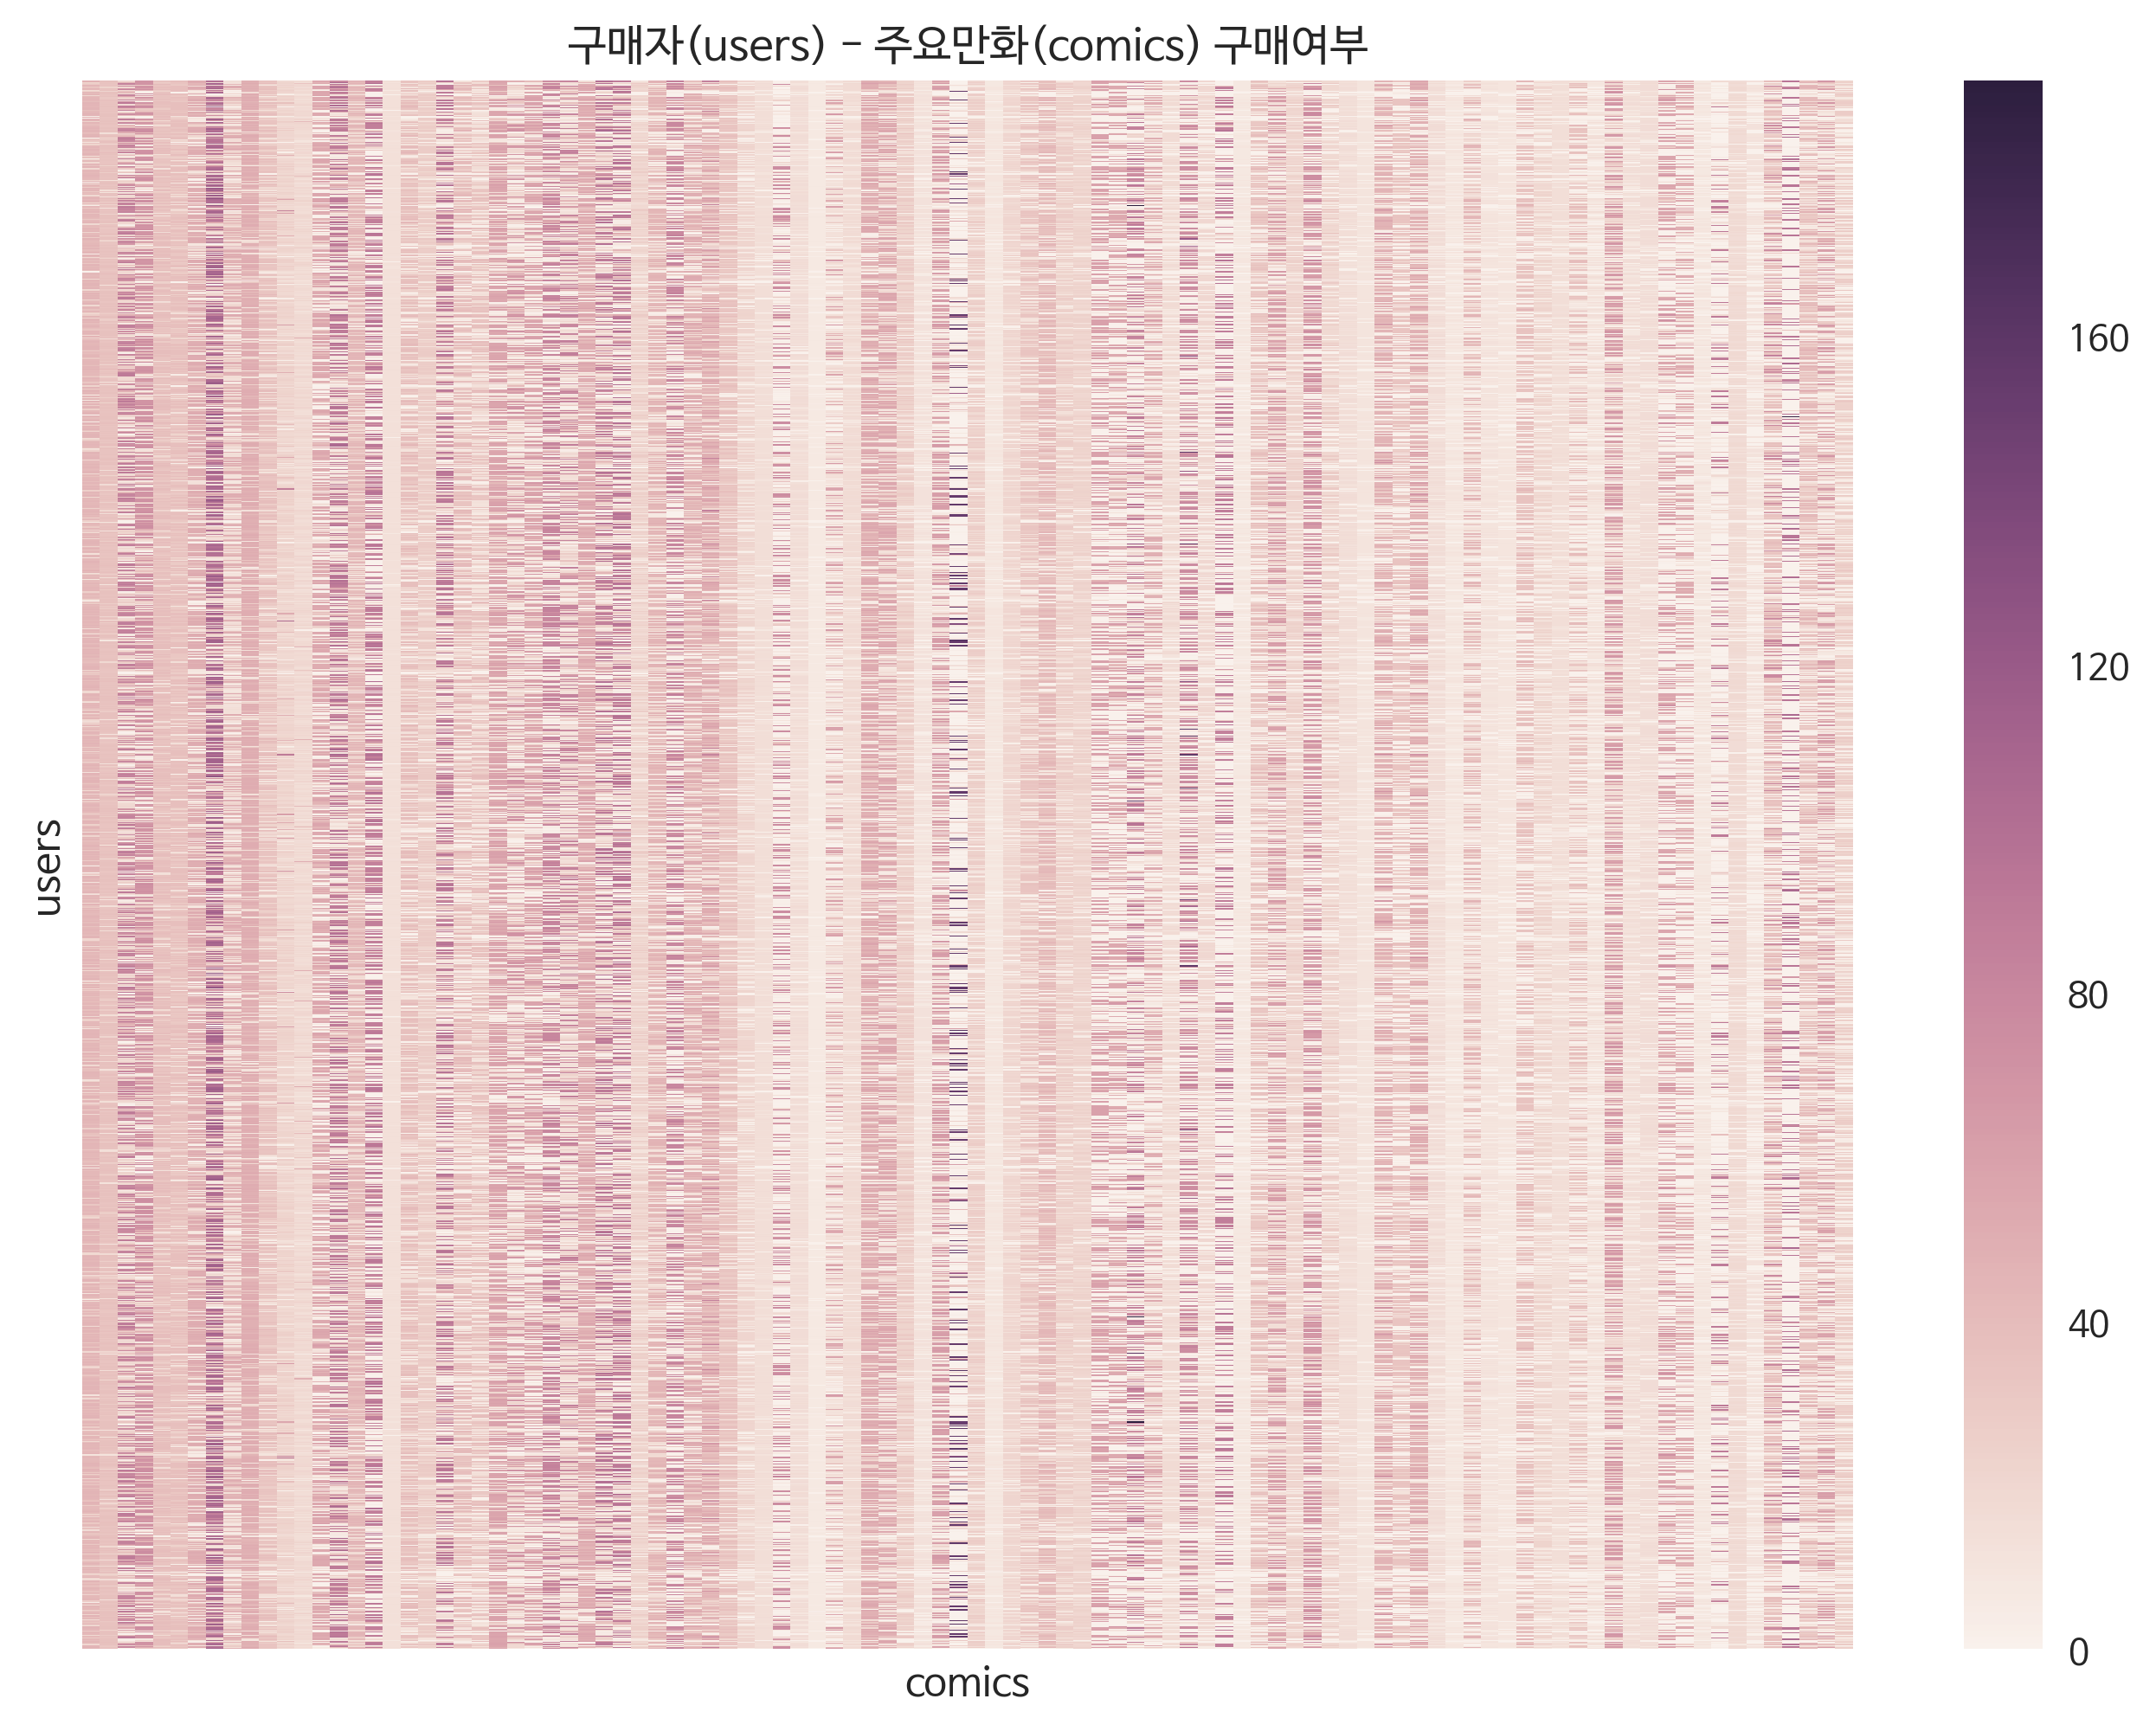

In [50]:
sns.heatmap(user_comic_table, xticklabels=False, yticklabels=False)
plt.title('구매자(users) - 주요만화(comics) 구매여부')
plt.show()

이 표에서 하나의 데이터가 뜻하는 것은, "한 명의 유저가 하나의 주요만화를 얼만큼 많이 구매 했는가"이다.

이 표로 알 수 있는 정보는 어떤 만화는 촘촘한데, 어떤 만화는 공백이 틈틈히 껴있는 만화도 있다. 이는 즉, 완전 인기가 있는것과 취향을 타는 만화가 있다는 것으로 추정된다.

또한, 만화마다 총 편수가 다 달라서, 이 표를 그대로 예측에 쓰면 안되므로, 이를 각 만화를 기준으로(위 그림에서의 한 열을 뜻함) 최대치를 계산후, 그 값을 각 데이터에 나눠서 scaling하면, 한 명의 유저가 하나의 주요만화에 대한 구매 정도를 나타낼 수가 있다. 

그리고 유저별로 평균을 내서(행으로 평균을 내는 것), 그 유저의 평균 구매 여부정도를 여기서 **구매력(purchasing power)**이라고 명칭을 지어주었다. 이는 유저가 얼만큼 만화를 자주 구매하는지 나타내는 지표다.

이를 카테고리화 시켜서 0~9까지의 구매 정도로 전환 해주었다. 큰 숫자의 카테고리 일수록 더 높은 구매력을 가진다는 뜻이다.

### 최종적으로 training에 사용한 Features

총 650,965건 ,64개의 Features를 사용한다.

| 명칭 | column이름 |갯수|특징|
|:--|:--|:--:|:--:|
|사용 플랫폼 A~D  | plat_A ~D | 4| one hot encoded|
|개인정보2|privacy_2| 1| |
|목록 진입시점 방문 총 세션 수| total_sessions| 1| category |
|작품 태그 정보1~5|comic_tag1 ~5| 5| one hot encoded으로 추측|
|구매할 때 필요한 코인|coin_needed| 1| category(혹은 numbers) |
|완결 여부|end|1| category |
|스케쥴 정보|schedule1 ~10| 10| one hot encoded|
|장르 정보|genre1 ~18| 18| one hot encoded|
|해당 작품의 마지막 에피소드 발행 시점|last_episode|1| category |
|단행본 여부|book|1| category |
|작품 발행 시점|comic_start|1| category |
|총 발행 에피소드 수|total_episode|1| category |
|유저의 성향 정보|user_tendency1 ~16|16| numbers |
|구매력|purchasing_power|1| category |

<br><br/>

## Import Model
---

In [1]:
# coding utf-8
import numpy as np
import models

settings = {'n_kfold': 10,
            'n_estimator': 10,
            'accuracy_gage': 0.8,
            'criterion': 'gini',
            'report': True,
            'train_fileloc': './data/lezhin_dataset_v2_training.tsv',
            'test_fileloc': './data/lezhin_dataset_v2_test_without_label.tsv'}

sess = models.Run(settings)
sess.initiate()

## Random Forest
---
어떤 변수가 분류에 영향을 미치는지 독립변수의 중요도를 계산하기 위해서 Random Forest 방법을 썼다.

In [2]:
model_forest = sess.forest()

Feature importance
1. feature 4: total_session (0.098992)
2. feature 59: user_tendency13 (0.085589)
3. feature 48: user_tendency2 (0.074499)
4. feature 51: user_tendency5 (0.070291)
5. feature 49: user_tendency3 (0.065845)
6. feature 60: user_tendency14 (0.064131)
7. feature 54: user_tendency8 (0.055987)
8. feature 63: purchasing_power (0.055227)
9. feature 52: user_tendency6 (0.042277)
10. feature 55: user_tendency9 (0.030198)
11. feature 50: user_tendency4 (0.025166)
12. feature 47: user_tendency1 (0.024253)
13. feature 39: comic_start (0.023988)
14. feature 6: comic_tag1 (0.023713)
15. feature 40: total_episode (0.020320)
16. feature 8: end (0.016736)
17. feature 16: schedule8 (0.014996)
18. feature 37: last_episode (0.014993)


In [3]:
sess.CV_test(model_forest)

ROC Auc Score for model-Random Forest is 0.9958
Corss Validation Score for model-Random Forest is 0.7313


트레이닝 결과는 99.58%로 분류를 할 수 있으며, KFold로 9:1 비율의 train과 test set으로 나눠서 검증한 결과 73.13%의 정확도를 나타낸다.

이결과로 구매여부에 대한 예측은 주로 사용자에 대한 정보가 중요하다는 것을 알 수 있다. user_tendency와 purchasing power가 상위권을 이루고 있고, 그 뒤로 만화의 특성이 순위에 올라와있는 모습이다.

In [11]:
guess = sess.test(model_forest)
np.savetxt('test_y_forest.txt', guess, fmt='%d')

안정감은 덜하지만 조금 더 빠르게 할 수 있게 일반 Decision Tree도 구현해보았다. (이게 최적의 결과는 아니다, 단지 어떤 feature가 쓰이는지 쉽게 보기 위함)

max_depth는 Random Forest에서 구한 feature중요도 갯수만큼 만 쓰게 설정 해놓았다. Graphviz로 dot형식의 파일을 열어서 어떻게 나누었는지 살펴 볼 수가 있다.

In [ ]:
model_tree = sess.tree()

In [8]:
sess.export_tree_dot(model_tree)

In [9]:
guess2 = sess.test(model_tree)
np.savetxt('test_y_tree.txt', guess2, fmt='%d')

또한, Tree를 그려볼 수도 있다. max_depth가 커질 수록 그림을 그려지기가 어려워, 여기서는 max_depth = 5로 다시 설정하고 그려보았다.

In [16]:
sess.preference_max_depth = 5

In [17]:
model_tree = sess.tree()

In [18]:
sess.CV_test(model_tree)

ROC Auc Score for model-Decision Tree is 0.6578
Corss Validation Score for model-Decision Tree is 0.7120


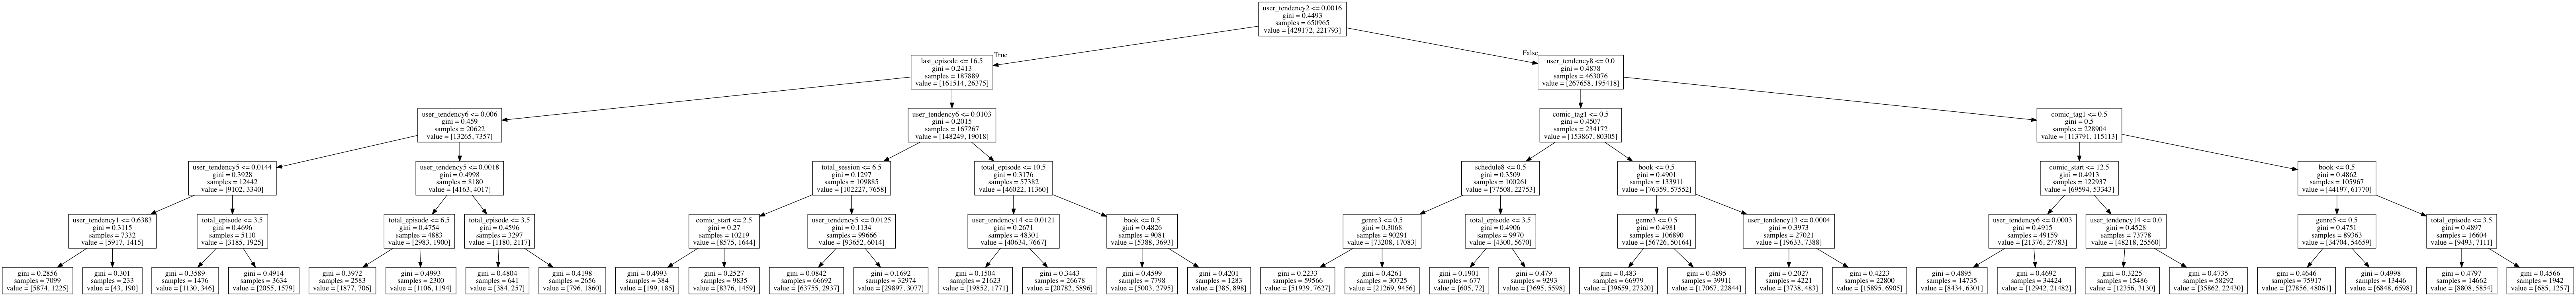

In [19]:
sess.draw_decision_tree(model_tree)

## 향후과제
---
1. 정확도를 더 높힐 수 있는 모델을 개발
2. 개인성향(user)와 만화(comic)특성을 score화 시켜서 곱한뒤 일종의 평점을 만들어내서, user-comic matrix로 만화 추천 시스템을 만들어 볼 것